### Description: This notebook demonstrates training VAE encoder on GP aggregates and disease mapping using aggVAE(section 5.2.7 - 5.2.12, the aggVAE components). This notebook also can be used to reproduce values in tables 5-10

In [1]:
import os
import jax
import jax.nn as nn
import math
import itertools
from jax import lax, random
from jax.example_libraries import stax
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpyro
import pickle
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, RenyiELBO
import arviz as az
import sys
from pyprojroot import here
import time
import plotly.express as px
import geopandas as gpd
sys.path.append(str(here() / "simulation study" / "src"))
# Import our modular components
from kernels import exp_sq_kernel, M_g
from loader_jkt import load_data
from gp import gp_aggr
from vae import vae_model, vae_guide, vae_decoder
from plotting import plot_process, plot_incidence_map
import matplotlib.pyplot as plt
from numpyro.infer import NUTS, MCMC, Predictive, init_to_median, init_to_uniform, init_to_sample, init_to_mean, init_to_value

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data

In [4]:
# Load the spatial grid and polygon data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


## 2. Set up aggVAE Model Parameters

In [3]:
# Model configuration
args = {
    "x": spatial_data["x"],
    "gp_kernel": exp_sq_kernel,
    "noise": 1.e-2,
    "jitter": 1.e-2,
    "M_lo": jnp.array(spatial_data["pol_pts_lo"]),
    "M_hi":  jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    "vae_var": 0.1,
    "batch_size": 5,
    "hidden_dim": 50,
    "z_dim": 40,
    "learning_rate": 1e-3,
    "num_epochs": 29,
    "rng_key": PRNGKey(6)
}

## 3. Generate GP Samples

In [4]:
# Create predictive function for GP
from numpyro.infer import Predictive
# Draw samples from the prior
prior_samples = Predictive(gp_aggr, num_samples=5)(
    PRNGKey(6),
    config=args
)

# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

plot_process(prior_samples_arviz.prior.gp_aggr.values)

## 4. Train VAE

In [115]:
# Initialize SVI
optimizer = numpyro.optim.Adam(step_size=1e-3)
agg_gp_predictive = Predictive(gp_aggr,num_samples = 5)
@jax.jit
def epoch_train(rng_key, svi_state, num_train):
    def body_fn(i, val):
        rng_key_i = jax.random.fold_in(rng_key, i) #Array(2,)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = jax.random.split(rng_key_i, 4) #Tuple(Array(2,) x 4)
        loss_sum, svi_state = val #val --svi_state

        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"] #(5,116) <- num_samples : 5, total_districts : 116
        #* svi is where the vae_model & vae_guide gets applied
        svi_state, loss = svi.update(svi_state, batch)
        loss_sum += loss / args["batch_size"]
        return loss_sum, svi_state

    return lax.fori_loop(lower = 0, upper = num_train, body_fun=body_fn, init_val=(0.0, svi_state))

@jax.jit
def eval_test(rng_key, svi_state, num_test):
    def body_fn(i, loss_sum):
        rng_key_i = jax.random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_varm, rng_key_noise = jax.random.split(rng_key_i, 4)
        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"]
        #* svi is where the vae_model & vae_guide gets applied
        loss = svi.evaluate(svi_state, batch) / args["batch_size"]
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(lower = 0, upper = num_test,body_fun =  body_fn, init_val = 0.0)
    loss = loss / num_test
    return loss

## Hyerparameter tuning for h and z  --> used to produce values in Table 6

In [ ]:
# Define hyperparameter grid
hidden_dims = [20, 30, 40, 50]
z_dims = [20, 30, 40, 50]

# Store results
test_loss_results_final = {}
test_loss_results_mean = {}

num_train = 100
num_test = 100
num_epochs = 20

for hidden_dim, z_dim in itertools.product(hidden_dims, z_dims):
    print(f"Training with hidden_dim={hidden_dim}, z_dim={z_dim}")

    args["hidden_dim"] = hidden_dim
    args["z_dim"] = z_dim

    # Initialize optimizer and SVI
    adam = numpyro.optim.Adam(step_size=args["learning_rate"])
    # Pass vae_var to vae_model using a lambda function
    svi = SVI(
        lambda batch: vae_model(batch, hidden_dim, z_dim, args["vae_var"]),
        lambda batch: vae_guide(batch, hidden_dim, z_dim),
        adam,
        RenyiELBO(),
    )

    # Split RNG keys
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"]

    # Initialize SVI state
    svi_state = svi.init(rng_key_init, init_batch)

    # Pre-allocate test loss array
    test_loss_list = jnp.zeros(num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
        t_start = time.time()

        train_loss, svi_state = epoch_train(rng_key_train, svi_state, num_train)
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list = test_loss_list.at[epoch].set(test_loss)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f} ({time.time() - t_start:.2f} s)")

        if math.isnan(test_loss):  # Stop early if NaN
            print(f"NaN encountered at hidden_dim={hidden_dim}, z_dim={z_dim}. Skipping...")
            break  # Stop training if NaN occurs

    # Store results only if valid
    if not math.isnan(test_loss_list[-1]):
        test_loss_results_final[(hidden_dim, z_dim)] = test_loss_list[-1]
        test_loss_results_mean[(hidden_dim, z_dim)] = jnp.nanmean(test_loss_list)
        print(f"Final Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {test_loss_list[-1]}")
        print(f"Mean Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {jnp.nanmean(test_loss_list)}")

print("Grid search complete.")
print("Results:", test_loss_results_final)
print("Mean Test Loss Results:", test_loss_results_mean)

Training with hidden_dim=20, z_dim=20
Epoch: 0, Train Loss: 18298746880.00, Test Loss: 131595576.00 (13.33 s)
Epoch: 1, Train Loss: 28472915968.00, Test Loss: 172952064.00 (0.22 s)
Epoch: 2, Train Loss: 16623357952.00, Test Loss: 162045552.00 (0.22 s)
Epoch: 3, Train Loss: 14992008192.00, Test Loss: 4303764992.00 (0.22 s)
Epoch: 4, Train Loss: 3684347674624.00, Test Loss: 9992914944.00 (0.22 s)
Epoch: 5, Train Loss: 15526137856.00, Test Loss: 361663070208.00 (0.22 s)
Epoch: 6, Train Loss: 18069397504.00, Test Loss: 143981696.00 (0.22 s)
Epoch: 7, Train Loss: 12369376256.00, Test Loss: 140706416.00 (0.22 s)
Epoch: 8, Train Loss: 13913288704.00, Test Loss: 132283504.00 (0.22 s)
Epoch: 9, Train Loss: 10682062848.00, Test Loss: 94213080.00 (0.22 s)
Epoch: 10, Train Loss: 12442591232.00, Test Loss: 130829952.00 (0.22 s)
Epoch: 11, Train Loss: 13886770176.00, Test Loss: 140524736.00 (0.22 s)
Epoch: 12, Train Loss: 12460086272.00, Test Loss: 90007440.00 (0.22 s)
Epoch: 13, Train Loss: 1346216

### Optimal hyperparams used is (50, 40) at the end

In [ ]:
#-------------------------- Train VAE -------------------------- #
run = True
if run:
    adam = numpyro.optim.Adam(step_size = args["learning_rate"])
    svi = SVI(
        model=lambda batch: vae_model(batch, args["hidden_dim"], args["z_dim"], args["vae_var"]),
        guide=lambda batch: vae_guide(batch, args["hidden_dim"], args["z_dim"]),
        optim=adam,
        loss=RenyiELBO(),
    )
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"],3)
    #(num_samples, num_regions)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"] #(num_samples, num_regions) <- i.e (5,58)
    svi_state = svi.init(rng_key_init, init_batch)

    test_loss_list = []

    for i in range(args["num_epochs"]):
        rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
        t_start = time.time()
        num_train = 1000
        # Where forward/backward pass gets called for train
        train_loss , svi_state = epoch_train(rng_key_train, svi_state, num_train)
        num_test = 1000
        # Where forward/backward pass gets called for test
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list += [test_loss]

        print("Epoch : {}, train loss : {:.2f}, test loss : {:.2f} ({:.2f} s.)".format(i, train_loss, test_loss, time.time() - t_start))
        if np.isnan(test_loss):
            break

Epoch : 0, train loss : 63324172288.00, test loss : 3790235.75 (2.17 s.)
Epoch : 1, train loss : 2249416960.00, test loss : 1871734.88 (2.12 s.)
Epoch : 2, train loss : 1701763840.00, test loss : 1547703.62 (2.13 s.)
Epoch : 3, train loss : 1208848384.00, test loss : 713949.56 (2.13 s.)
Epoch : 4, train loss : 364533504.00, test loss : 46471.78 (2.13 s.)
Epoch : 5, train loss : 42744768.00, test loss : 60777.09 (2.13 s.)
Epoch : 6, train loss : 38784588.00, test loss : 36633.82 (2.13 s.)
Epoch : 7, train loss : 33073066.00, test loss : 29483.56 (2.13 s.)
Epoch : 8, train loss : 2330169856.00, test loss : 2698056.75 (2.14 s.)
Epoch : 9, train loss : 2309892096.00, test loss : 2195475.25 (2.11 s.)
Epoch : 10, train loss : 2275153408.00, test loss : 1753061.75 (2.11 s.)
Epoch : 11, train loss : 1805689216.00, test loss : 1734156.88 (2.13 s.)
Epoch : 12, train loss : 2367365888.00, test loss : 1983115.12 (2.12 s.)
Epoch : 13, train loss : 2351059456.00, test loss : 2238835.75 (2.13 s.)
Epo

In [ ]:
vae_params = svi.get_params(svi_state)

In [ ]:
save_dir = "/content/model_weights/aggVAE"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"aggVAE_e{args['num_epochs']}_h{args['hidden_dim']}_z{args['z_dim']}_batch{args['batch_size']}.pkl")

with open(save_path, "wb") as file:
    pickle.dump(vae_params, file)

print(f"VAE parameters saved to {save_path}")

VAE parameters saved to /content/model_weights/aggVAE/aggVAE_e29_h50_z40_batch100.pkl


## Run MCMC using trained VAE encoder --> section 5.2.9

In [6]:
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40_batch5.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

### This function is to use the decoder to generate aggVAE priors as reconstructions of aggGP priors learnt by the encoder

In [7]:
N = 6

def vae_sample(args):
    dec_params = args["decoder_params"]
    z_dim, h_dim = dec_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    dec_init_fn, dec_apply_fn = vae_decoder(h_dim, N)
    x_recon = dec_apply_fn(dec_params, z)
    vae_aggr = numpyro.deterministic("vae_aggr", x_recon)
    return vae_aggr

rng_key, rng_key_predict = random.split(random.PRNGKey(3))
vae_predictive = Predictive(vae_sample, num_samples = 5)
vae_draws = vae_predictive(rng_key_predict, args)["vae_aggr"]

### This function covers steps 5.2.7 - 5.2.8

In [8]:
# ------------------- Func for Agg VAE Prev ------------------- #
def prev_model_vae_aggr(config=None):

    if config is None:
        config = {}

    # Set defaults
    x = config.get('x', None)
    gp_kernel = config.get('gp_kernel', exp_sq_kernel)
    noise = config.get('noise', 1e-4)
    jitter = config.get('jitter', 1e-4)
    M_lo = config.get('M_lo', None)
    M_hi = config.get('M_hi', None)
    kernel_length_prior = config.get('kernel_length', dist.InverseGamma(4, 1))
    kernel_var_prior = config.get('kernel_var', dist.LogNormal(0, 0.1))
    pop_density = config.get('pop_density', None)
    urban_frac = config.get('urban_frac', None)
    hdi_index = config.get('hdi_index', None)
    count = config.get("count", None)

     # Total cases: pass in province level dengue case counts, mask district level ones as NaN
    count_mask = ~jnp.isnan(count)

    total_population = config.get('total_population', None)
    is_prior_pred = config.get('prior_pred', False)
    out_dims = config.get('out_dims', 6)

    # GP
    config_gp = config.copy()
    config_gp['x'] = x
    config_gp['gp_kernel'] = gp_kernel
    config_gp['noise'] = noise
    config_gp['jitter'] = jitter
    config_gp['M_lo'] = M_lo
    config_gp['M_hi'] = M_hi
    config_gp['kernel_length'] = kernel_length_prior
    config_gp['kernel_var'] = kernel_var_prior

    # get the decoder parameter, and sample latent variables z from a standard  --> section 5.2.7
    decoder_params = config["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))

    #Instantiate decoder, apply the decoder to z to get aggVAE priors vae_aggr --> section 5.2.7
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) 
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))

    #scaling factor to scale vae_aggr to the appropriate scale for accurate dengue case count predictions --> section 5.2.8
    s = numpyro.sample("sigma1", dist.HalfNormal(200))

    #get the scaled vae_aggr as vae
    vae = numpyro.deterministic("vae", s * vae_aggr)

    # BHM modelling --> section 5.2.8
    # Assign priors to model the fixed effects
    b0 = numpyro.sample("b0", dist.Normal(100, 10))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    #the linear predictor model --> section 5.2.8
    lp = numpyro.deterministic("lp", nn.softplus(b0 +
                                      vae +
                                      b_pop_density * pop_density +
                                      b_hdi * hdi_index +
                                      b_urban * urban_frac))

    # Gaussian variance --> section 5.2.8
    sigma = numpyro.sample("sigma", dist.HalfNormal(5))

    # Predict dengue case counts at both province and district - levels using the lp model
    full_pred_cases = numpyro.sample(
        "full_pred_cases",
        dist.Normal(lp, sigma))

    # Use masking to hide observed case count data at district level from the model, so feed province level data only to the model
    # This is useful for posterior predictive checks!
    with numpyro.handlers.mask(mask=count_mask):
        numpyro.sample(
            "pred_cases",  
            dist.Normal(lp, sigma),
            obs=None if is_prior_pred else count)

    # Store full predictions 
    numpyro.deterministic("pred_cases_out", full_pred_cases)


### Load the data and filter for passing only individual years to the BHM

In [22]:
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data
year_data = 2022
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2022



### Set the aggVAE model parameters

In [9]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [10]:
#define the BHM used
model =  prev_model_vae_aggr

#define the MCMC params used
prob = 0.9
tree = 18

In [11]:
# Define the sampler
sampler = NUTS(model, target_accept_prob = prob, max_tree_depth = tree)
mcmc = MCMC(sampler,
            num_warmup=1000,
            num_samples=1000,
            num_chains=4,
            chain_method="vectorized")

start = time.time()
mcmc.run(PRNGKey(2), config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")

sample: 100%|██████████| 2000/2000 [9:27:18<00:00, 17.02s/it]  


Time taken to run MCMC: 567 minutes


In [12]:
#save mcmc for aggVAE jkt yearly (change the year manually)
# Save the MCMC object as a pickle file
# Define the path where you want to save the MCMC files

save_dir = "../model weights/aggVAEPrev"
os.makedirs(save_dir, exist_ok=True)

# Define the file path where to save the MCMC object
file_path = os.path.join(save_dir, f"mcmc_jkt_{year_data}_{t_elapsed_min}min_z{args["z_dim"]}_prob{prob}_treedepth{tree}.pkl")

# Save the MCMC object as a pickle file
with open(file_path, 'wb') as f:
        pickle.dump(mcmc, f)

print(f"MCMC object for year {year_data} saved successfully at {file_path}.")

MCMC object for year 2022 saved successfully at ../model weights/aggVAEPrev\mcmc_jkt_2022_567min_z40_prob0.9_treedepth18.pkl.


In [ ]:
# creating  posterior predictive for posterior predictive checks
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.72      8.67     98.10     85.09    114.41       nan      1.01
             b_hdi     -0.07      0.86     -0.28     -1.43      1.51    904.59      1.01
     b_pop_density      0.47      1.16      0.48     -1.25      1.80      4.09      1.37
           b_urban     -0.08      0.89     -0.39     -1.39      1.60     37.05      1.04
full_pred_cases[0]   2112.72      6.29   2112.35   2103.26   2123.13   2145.95      1.00
full_pred_cases[1]    376.25    138.00    348.80    198.18    612.92     22.35      1.09
full_pred_cases[2]    177.32    152.57    151.07     -7.99    399.83      6.58      1.22
full_pred_cases[3]    453.48    149.47    437.87    277.01    711.55     11.43      1.13
full_pred_cases[4]    612.62    151.25    594.74    424.93    847.68     17.56      1.10
full_pred_cases[5]    585.21    126.98    565.96    393.14    751.71    404.43      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],2112.720,6.289,2100.305,2126.072,0.135,0.468,2397.0,1306.0,1.53
pred_cases_out[1],376.249,138.002,147.484,678.758,19.721,6.712,45.0,407.0,1.09
pred_cases_out[2],177.320,152.574,-9.871,437.506,39.749,3.751,21.0,664.0,1.14
pred_cases_out[3],453.479,149.471,190.497,748.053,29.805,5.989,22.0,374.0,1.15
pred_cases_out[4],612.623,151.249,377.967,923.387,24.903,8.871,26.0,365.0,1.12
pred_cases_out[5],585.209,126.977,342.223,785.918,6.295,13.682,546.0,601.0,1.53
lp[0],2112.906,4.584,2103.844,2122.495,0.085,0.348,3060.0,1123.0,1.53
lp[1],376.083,137.902,146.292,677.864,19.980,6.706,42.0,419.0,1.09
lp[2],177.412,152.554,0.000,434.777,39.697,3.762,21.0,377.0,1.15
lp[3],453.669,149.346,210.748,770.045,29.707,5.964,22.0,369.0,1.15


### Posterior Predictive Checks - Convergence diagnostics (high effects)

In [24]:
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 22
Average ESS for all aggVAE-low effects : 23
Max r_hat for all aggVAE-low : 1.0700000524520874
Average ESS for all aggVAE-high effects : 22
Max r_hat for all aggVAE-high : 1.100000023841858


### Append predictions to the original df for plotting

In [25]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE as percentage of each observation, then average
mae_pct_all = []

for true, pred in zip(y_true, y_pred):
    if true != 0:
        abs_error = abs(true - pred)
        pct_error = (abs_error / true) * 100
        mae_pct_all.append(pct_error)

mae_pct_avg_all_obs = np.mean(mae_pct_all)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of actual value (averaged over all observations): {mae_pct_avg_all_obs:.2f}%")

RMSE: 95.1488
MAE as % of average observed prevalence: 18.22%


### Plot predicted vs actual observed prevalence at province level

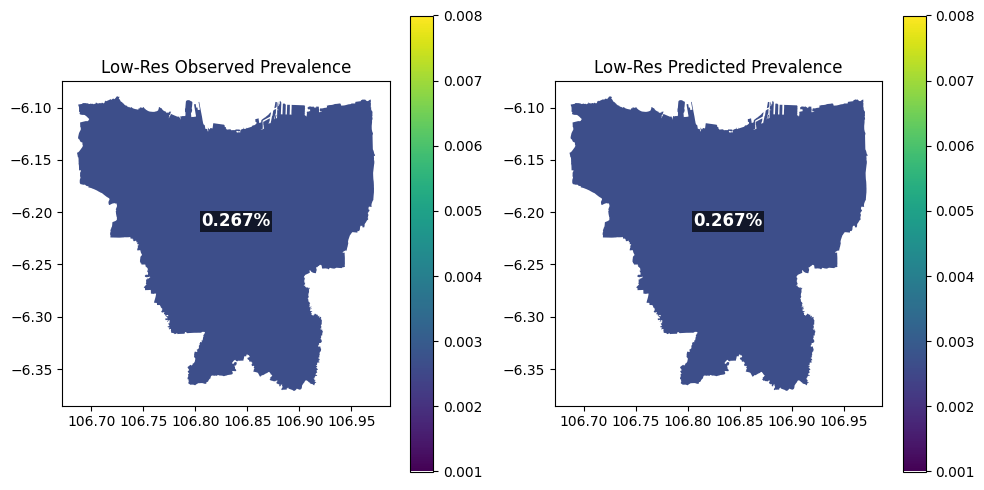

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### Plot predicted vs actual observed prevalence at district level

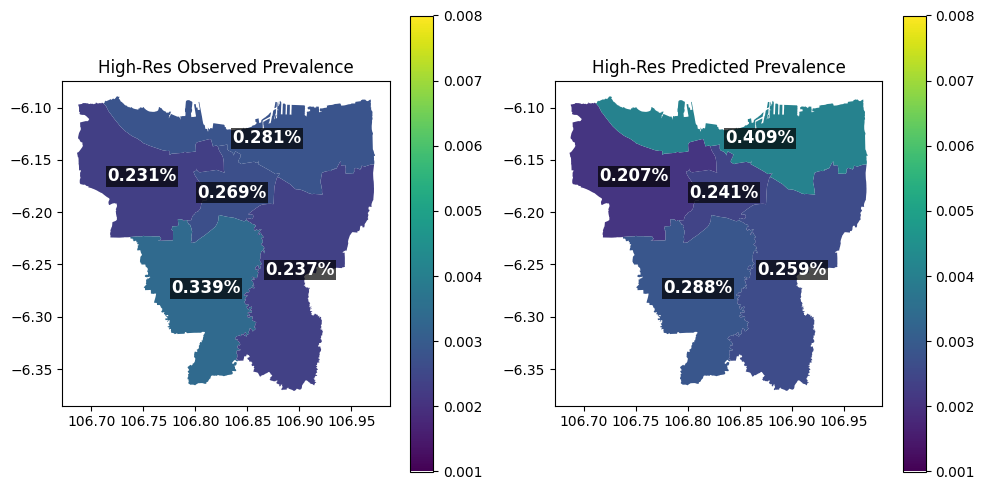

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("../data/processed/df_hi_jkt_2022_aggVAE_preds.csv")

# MCMC Fine Tuning Results (see which one produces the best Rhat and ESS. If both Rhat < 1.01 and ESS > 100 measure based on MAE (%) and RMSE)
# This section produces values for tables 5-10

In [9]:
model =  prev_model_vae_aggr

In [10]:
#load MCMC objects
with open("../model weights/aggVAEPrev/mcmc_jkt_2023_23min_z40_prob0.85_treedepth15.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_31min_z40_prob0.9_treedepth15.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_59min_z40_prob0.95_treedepth15.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_1min_z30_default_batch5.pkl", "rb") as f_4:
    mcmc_4 = pickle.load(f_4)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_3min_z40_default_batch5.pkl", "rb") as f_5:
    mcmc_5 = pickle.load(f_5)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_5min_z40_default_batch100.pkl", "rb") as f_6:
    mcmc_6 = pickle.load(f_6)

In [11]:
#load the 2023 dataset
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data
year_data = 2023
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2023



## Determine the best batch size, on 2023 dataset and default MCMC settings (for ease of computation) - Rhat, ESS values for Table 5

### MCMC 5 (z = 40, n = 1000) - 2023, batch size 5

In [12]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40_batch5.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [13]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [14]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_5.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_5,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_5.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.26      9.83     99.68     83.72    114.89     61.90      1.05
             b_hdi     -0.37      1.10     -0.33     -2.23      1.46      8.57      1.27
     b_pop_density      0.33      0.97      0.32     -1.21      1.91     35.71      1.10
           b_urban     -0.31      1.39     -0.11     -2.67      1.56      3.49      1.64
full_pred_cases[0]   1557.16     13.36   1560.03   1539.70   1576.54     11.21      1.40
full_pred_cases[1]    214.16    183.06    176.60    -11.40    429.02      2.31      2.86
full_pred_cases[2]    126.64    146.01      8.37    -13.09    326.79      2.54      2.22
full_pred_cases[3]    257.65    203.07    212.67    -11.23    490.37      2.24      3.12
full_pred_cases[4]    339.13    237.29    334.41    -13.65    586.18      2.16      3.75
full_pred_cases[5]    332.03    211.15    393.10     -9.20    543.93      2.27      3.02
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1557.161,13.365,1524.115,1576.543,4.291,4.554,18.0,17.0,1.19
pred_cases_out[1],214.156,183.055,-13.123,466.704,84.566,15.922,5.0,28.0,2.04
pred_cases_out[2],126.636,146.013,-18.084,353.392,63.819,8.875,7.0,36.0,1.61
pred_cases_out[3],257.647,203.067,-13.528,525.974,95.191,23.445,5.0,58.0,2.10
pred_cases_out[4],339.133,237.288,-15.512,635.931,113.318,40.538,5.0,27.0,2.10
pred_cases_out[5],332.030,211.151,-10.150,582.005,98.536,38.692,6.0,22.0,2.04
lp[0],1559.488,8.428,1543.307,1576.077,2.291,2.280,21.0,14.0,1.14
lp[1],214.571,182.556,0.000,465.974,84.342,15.970,5.0,4.0,2.23
lp[2],127.030,145.658,0.000,344.522,63.640,8.902,6.0,5.0,1.98
lp[3],257.442,203.123,0.000,525.424,95.288,23.453,5.0,4.0,2.24


In [15]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_5.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 5
Average ESS for all aggVAE-low effects : 5
Max r_hat for all aggVAE-low : 1.3799999952316284
Average ESS for all aggVAE-high effects : 4
Max r_hat for all aggVAE-high : 1.590000033378601


### MCMC 6 (z = 40, n = 1000) - 2023, batch size 100

In [16]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40_batch100.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [17]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [18]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_6.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_6,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_6.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    102.49     11.96    103.78     85.09    116.84      2.00     47.46
             b_hdi     -0.04      1.13      0.38     -1.97      1.03      2.01     21.86
     b_pop_density      0.12      0.65      0.38     -0.99      0.69      2.01     20.33
           b_urban     -1.09      1.02     -0.84     -2.80      0.00      2.05      7.04
full_pred_cases[0]   1571.17     10.64   1571.71   1549.49   1583.00      5.30      1.61
full_pred_cases[1]     58.13     99.78     15.12    -27.80    228.12      2.00    180.88
full_pred_cases[2]     16.47     39.62      4.46    -19.28     84.02      2.02     18.40
full_pred_cases[3]     75.47    123.46     12.61     -5.57    288.77      2.00     90.15
full_pred_cases[4]    117.87    160.22     46.26     -8.78    389.85      2.00    244.22
full_pred_cases[5]    182.90    126.00    152.72     44.48    382.38      2.00    168.41
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1571.171,10.639,1541.461,1583.036,4.005,3.210,7.0,17.0,1.98
pred_cases_out[1],58.134,99.781,-27.805,228.696,49.690,27.813,5.0,19.0,3.14
pred_cases_out[2],16.469,39.624,-23.626,85.528,19.700,10.099,5.0,15.0,2.99
pred_cases_out[3],75.472,123.457,-5.579,290.024,61.477,35.338,4.0,13.0,3.61
pred_cases_out[4],117.867,160.222,-8.772,390.995,79.789,44.053,4.0,12.0,3.85
pred_cases_out[5],182.901,125.998,43.009,382.504,62.745,29.776,4.0,11.0,3.51
lp[0],1571.111,13.858,1544.985,1599.719,3.861,1.895,13.0,30.0,1.23
lp[1],57.088,98.894,0.000,229.270,49.248,28.431,5.0,4.0,3.22
lp[2],20.193,34.992,0.000,81.994,17.420,10.065,5.0,4.0,3.30
lp[3],71.560,123.963,0.000,287.246,61.732,35.638,4.0,4.0,3.73


In [19]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_6.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 2
Average ESS for all aggVAE-low effects : 2
Max r_hat for all aggVAE-low : 28.40999984741211
Average ESS for all aggVAE-high effects : 2
Max r_hat for all aggVAE-high : 35.720001220703125


## Determine the best target_accept_prob, setting tree depth = 20, on 2023 dataset --> used to produce values for Tables 7 (Rhat, ESS) and 8 (Rhat, ESS, RMSE, MAE (%))

### MCMC 1 (z = 40, n = 1000 Inference, target accept prob = 0.85, tree depth 15) - 2023, batch size 5 (table 7)

In [20]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.01      9.70     99.87     84.51    115.72   3609.96      1.00
             b_hdi      0.08      1.02      0.08     -1.58      1.75   1460.67      1.00
     b_pop_density      0.08      1.02      0.08     -1.55      1.75   2591.65      1.00
           b_urban      0.05      1.01      0.03     -1.55      1.75   1555.27      1.00
full_pred_cases[0]   1562.00      8.06   1562.00   1548.86   1575.06   2861.36      1.00
full_pred_cases[1]    328.06    136.39    328.80     97.27    551.71    640.25      1.01
full_pred_cases[2]    192.13    138.94    190.00    -11.34    375.45    722.12      1.00
full_pred_cases[3]    387.86    141.02    392.14    158.52    619.72    653.50      1.01
full_pred_cases[4]    503.53    139.13    506.97    271.81    717.27    598.49      1.01
full_pred_cases[5]    473.46    137.01    463.61    262.52    679.28    593.84      1.00
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.999,8.059,1546.667,1578.896,0.152,0.298,3172.0,1583.0,1.02
pred_cases_out[1],328.063,136.390,85.323,629.426,5.378,3.757,649.0,628.0,1.00
pred_cases_out[2],192.125,138.936,-16.369,409.060,5.165,2.994,727.0,931.0,1.00
pred_cases_out[3],387.857,141.025,127.517,675.265,5.512,3.774,662.0,761.0,1.01
pred_cases_out[4],503.530,139.129,240.873,782.733,5.667,4.715,627.0,638.0,1.01
pred_cases_out[5],473.460,137.011,226.650,732.950,5.599,7.737,729.0,568.0,1.00
lp[0],1562.085,5.905,1550.519,1574.146,0.106,0.203,3418.0,1817.0,1.01
lp[1],328.052,136.223,0.000,540.643,5.376,3.764,646.0,609.0,1.00
lp[2],192.125,138.902,0.000,409.759,5.159,2.983,691.0,970.0,1.01
lp[3],387.998,140.696,126.688,671.645,5.504,3.784,661.0,664.0,1.01


In [21]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 805
Average ESS for all aggVAE-low effects : 819
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 802
Max r_hat for all aggVAE-high : 1.0099999904632568


In [22]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [23]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE as percentage of each observation, then average
mae_pct_all = []

for true, pred in zip(y_true, y_pred):
    if true != 0:
        abs_error = abs(true - pred)
        pct_error = (abs_error / true) * 100
        mae_pct_all.append(pct_error)

mae_pct_avg_all_obs = np.mean(mae_pct_all)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of actual value (averaged over all observations): {mae_pct_avg_all_obs:.2f}%")

RMSE: 102.7880
MAE as % of actual value (averaged over all observations): 29.04%


### MCMC 2 (z = 40, n = 1000, target accept prob = 0.9, tree depth = 15) - year is 2023 (table 7)

In [24]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.01      9.62    100.00     83.39    115.08   2589.66      1.00
             b_hdi      0.03      1.00      0.04     -1.64      1.62   1361.65      1.00
     b_pop_density      0.07      0.99      0.07     -1.72      1.53   2691.22      1.00
           b_urban      0.04      1.01      0.04     -1.56      1.81   1177.84      1.00
full_pred_cases[0]   1561.71      7.99   1561.94   1549.13   1574.72   1885.27      1.00
full_pred_cases[1]    324.35    138.10    324.65     96.91    542.57    434.25      1.00
full_pred_cases[2]    190.59    139.72    184.32    -14.21    376.21    492.93      1.01
full_pred_cases[3]    385.45    142.98    387.88    148.58    606.22    443.60      1.00
full_pred_cases[4]    499.71    141.24    502.05    274.02    713.02    415.69      1.00
full_pred_cases[5]    465.99    133.54    455.03    248.61    653.35    447.20      1.00
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.707,7.994,1545.754,1577.814,0.183,0.380,2361.0,1179.0,1.02
pred_cases_out[1],324.347,138.098,63.302,598.177,6.533,5.281,469.0,580.0,1.00
pred_cases_out[2],190.594,139.721,-14.392,427.159,6.228,3.844,499.0,807.0,1.01
pred_cases_out[3],385.452,142.977,113.651,669.494,6.682,5.251,472.0,610.0,1.00
pred_cases_out[4],499.712,141.244,241.980,774.120,6.825,6.321,459.0,529.0,1.00
pred_cases_out[5],465.991,133.540,233.173,717.134,6.234,8.161,548.0,558.0,1.00
lp[0],1561.815,5.672,1551.341,1573.258,0.110,0.231,3056.0,1691.0,1.02
lp[1],324.399,138.147,0.000,533.418,6.542,5.282,466.0,569.0,1.00
lp[2],190.769,139.514,0.000,421.212,6.215,3.846,487.0,713.0,1.01
lp[3],385.324,142.915,114.318,670.423,6.683,5.228,469.0,617.0,1.00


In [25]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1117
Average ESS for all aggVAE-low effects : 1121
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 1117
Max r_hat for all aggVAE-high : 1.0099999904632568


In [26]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [27]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE as percentage of each observation, then average
mae_pct_all = []

for true, pred in zip(y_true, y_pred):
    if true != 0:
        abs_error = abs(true - pred)
        pct_error = (abs_error / true) * 100
        mae_pct_all.append(pct_error)

mae_pct_avg_all_obs = np.mean(mae_pct_all)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of actual value (averaged over all observations): {mae_pct_avg_all_obs:.2f}%")

RMSE: 99.3886
MAE as % of actual value (averaged over all observations): 28.17%


### MCMC 3 (z = 40, n = 1000, target accept prob = 0.95, tree depth = 15) - year is 2023 - BEST! (tables 7 and 8)

In [28]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_3.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_3,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_3.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     94.14     13.29     95.49     76.55    111.39      3.10      1.61
             b_hdi      0.00      0.87     -0.00     -1.51      1.47   1980.44      1.00
     b_pop_density      0.66      1.41      0.50     -1.15      2.53      3.09      1.63
           b_urban     -0.11      0.88     -0.40     -1.55      1.38     35.33      1.05
full_pred_cases[0]   1561.76      6.10   1560.95   1552.70   1571.04   2266.47      1.00
full_pred_cases[1]    284.49    133.42    253.29    125.91    534.28     10.63      1.14
full_pred_cases[2]    151.54    127.42     94.80    -11.04    335.73     18.67      1.09
full_pred_cases[3]    341.46    139.18    315.28    174.94    599.55     11.18      1.13
full_pred_cases[4]    452.43    145.50    437.44    294.28    703.99      8.05      1.18
full_pred_cases[5]    428.04    142.87    413.72    279.87    656.04      6.48      1.22
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.765,6.104,1550.237,1573.990,0.128,0.356,2996.0,1242.0,1.53
pred_cases_out[1],284.492,133.424,75.087,570.267,28.542,5.132,26.0,993.0,1.12
pred_cases_out[2],151.536,127.425,-11.503,383.134,21.008,9.817,106.0,878.0,1.25
pred_cases_out[3],341.463,139.184,129.350,640.734,28.889,3.612,28.0,1128.0,1.11
pred_cases_out[4],452.432,145.505,245.374,742.620,35.284,4.028,18.0,1157.0,1.17
pred_cases_out[5],428.042,142.873,241.529,706.711,38.669,5.783,13.0,1162.0,1.23
lp[0],1562.032,4.265,1553.375,1570.435,0.078,0.353,3607.0,1407.0,1.51
lp[1],284.662,133.259,82.326,575.608,28.448,4.585,24.0,1000.0,1.13
lp[2],151.414,127.360,0.000,382.323,20.962,9.896,82.0,899.0,1.27
lp[3],341.496,139.178,131.648,640.956,28.804,3.626,25.0,1171.0,1.12


In [29]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_3.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1260
Average ESS for all aggVAE-low effects : 1173
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 1278
Max r_hat for all aggVAE-high : 1.0


In [30]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

### error metrics for table 8

In [31]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE as percentage of each observation, then average
mae_pct_all = []

for true, pred in zip(y_true, y_pred):
    if true != 0:
        abs_error = abs(true - pred)
        pct_error = (abs_error / true) * 100
        mae_pct_all.append(pct_error)

mae_pct_avg_all_obs = np.mean(mae_pct_all)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of actual value (averaged over all observations): {mae_pct_avg_all_obs:.2f}%")

RMSE: 82.1362
MAE as % of actual value (averaged over all observations): 20.26%


In [ ]:
#this is the best parameters, so we download the predictions to be used
#df_hi.to_csv("../data/processed/df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 4 (z = 30, n = 1000 Inference, target accept prob = 0.8, tree depth 10 (default) - bc alr converged, so using default MCMC settings is ok) - 2023, batch size 5

In [32]:
args["z_dim"] = 30
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e50_h50_z30_batch5.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [33]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [34]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_4.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_4,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},)

# %%
print(mcmc_4.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.24      9.90    100.09     83.21    115.97    750.00      1.00
             b_hdi      0.12      1.00      0.14     -1.66      1.63    286.63      1.01
     b_pop_density      0.07      1.01      0.07     -1.53      1.71    390.24      1.00
           b_urban      0.11      1.02      0.14     -1.59      1.72    261.76      1.01
full_pred_cases[0]   1561.61      8.55   1562.05   1548.64   1575.12    528.91      1.01
full_pred_cases[1]    401.71    111.46    401.85    221.37    586.26    153.74      1.01
full_pred_cases[2]    281.03    121.40    281.80     94.96    492.20    158.71      1.01
full_pred_cases[3]    452.69    111.12    453.59    274.88    638.40    152.26      1.01
full_pred_cases[4]    559.50    101.98    560.76    400.04    737.20    151.75      1.01
full_pred_cases[5]    522.66    101.76    522.32    360.77    696.49    157.25      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.608,8.548,1544.568,1577.866,0.370,0.374,598.0,575.0,1.01
pred_cases_out[1],401.708,111.463,192.986,604.072,8.790,4.509,162.0,287.0,1.01
pred_cases_out[2],281.028,121.398,57.448,507.012,9.375,4.537,167.0,297.0,1.01
pred_cases_out[3],452.687,111.125,258.690,666.797,8.801,4.500,160.0,260.0,1.01
pred_cases_out[4],559.500,101.984,371.597,747.594,8.109,4.072,160.0,271.0,1.01
pred_cases_out[5],522.660,101.760,338.918,715.924,7.952,4.137,164.0,276.0,1.01
lp[0],1561.816,6.121,1550.059,1573.676,0.190,0.198,1136.0,1144.0,1.01
lp[1],401.773,111.323,192.326,601.550,8.783,4.514,162.0,278.0,1.01
lp[2],280.964,121.179,58.716,508.813,9.366,4.536,168.0,304.0,1.01
lp[3],452.630,110.831,256.236,663.117,8.780,4.476,161.0,268.0,1.01


In [35]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_4.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 472
Average ESS for all aggVAE-low effects : 476
Max r_hat for all aggVAE-low : 1.0
Average ESS for all aggVAE-high effects : 472
Max r_hat for all aggVAE-high : 1.0


In [36]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

### Error metrics for table 8

In [37]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE as percentage of each observation, then average
mae_pct_all = []

for true, pred in zip(y_true, y_pred):
    if true != 0:
        abs_error = abs(true - pred)
        pct_error = (abs_error / true) * 100
        mae_pct_all.append(pct_error)

mae_pct_avg_all_obs = np.mean(mae_pct_all)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of actual value (averaged over all observations): {mae_pct_avg_all_obs:.2f}%")

RMSE: 149.9626
MAE as % of actual value (averaged over all observations): 51.72%


## Determine the best target_accept_prob on the 2022 dataset

In [38]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40_batch5.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [39]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [40]:
#load the mcmc data u want
with open("../model weights/aggVAEPrev/mcmc_jkt_2022_53min_z40_prob0.95_treedepth15.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2022_567min_z40_prob0.9_treedepth18.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

In [41]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2022
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2022



### prob 0.95, tree depth 15 (Rhat, ESS for table 9)

In [42]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [43]:
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     98.70      9.10     95.92     85.42    115.10    101.36      1.06
             b_hdi     -0.06      0.83     -0.21     -1.42      1.40    423.72      1.01
     b_pop_density     -0.23      0.93     -0.50     -1.54      1.49     30.74      1.08
           b_urban     -0.28      0.90     -0.30     -1.81      1.27     14.38      1.12
full_pred_cases[0]   2113.63      5.33   2113.14   2106.00   2121.56   2098.48      1.01
full_pred_cases[1]    363.45    110.97    326.26    209.73    565.51     25.04      1.08
full_pred_cases[2]    154.32    131.36    118.38    -11.91    358.94      7.35      1.20
full_pred_cases[3]    447.92    118.24    412.70    302.16    671.71     22.84      1.08
full_pred_cases[4]    611.77    112.95    577.29    491.76    838.63     42.76      1.06
full_pred_cases[5]    575.38    103.02    597.69    416.80    730.94     24.27      1.08
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],2113.626,5.331,2103.990,2124.813,0.111,1.086,44.0,140.0,1.46
pred_cases_out[1],363.452,110.969,196.058,623.535,18.192,21.443,49.0,103.0,1.79
pred_cases_out[2],154.324,131.363,-11.087,406.882,34.856,18.604,22.0,116.0,1.17
pred_cases_out[3],447.922,118.240,268.871,721.431,19.506,22.522,41.0,101.0,1.27
pred_cases_out[4],611.770,112.949,437.286,876.374,14.949,22.362,57.0,114.0,1.43
pred_cases_out[5],575.378,103.024,385.401,779.605,17.044,16.267,28.0,154.0,1.52
lp[0],2113.355,4.032,2104.802,2121.255,0.062,0.661,1450.0,260.0,1.60
lp[1],363.513,110.940,191.210,619.194,18.103,21.514,48.0,97.0,1.78
lp[2],154.342,131.271,0.000,402.190,34.907,18.511,21.0,136.0,1.18
lp[3],447.906,118.158,268.330,720.032,19.504,22.511,40.0,113.0,1.28


In [44]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 11
Average ESS for all aggVAE-low effects : 11
Max r_hat for all aggVAE-low : 1.1299999952316284
Average ESS for all aggVAE-high effects : 11
Max r_hat for all aggVAE-high : 1.1399999856948853


### prob 0.9, tree depth 18 (best) (Rhat, ESS for table 10)

In [45]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [46]:
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.72      8.67     98.10     85.09    114.41       nan      1.01
             b_hdi     -0.07      0.86     -0.28     -1.43      1.51    904.59      1.01
     b_pop_density      0.47      1.16      0.48     -1.25      1.80      4.09      1.37
           b_urban     -0.08      0.89     -0.39     -1.39      1.60     37.05      1.04
full_pred_cases[0]   2112.72      6.29   2112.35   2103.26   2123.13   2145.95      1.00
full_pred_cases[1]    376.25    138.00    348.80    198.18    612.92     22.35      1.09
full_pred_cases[2]    177.32    152.57    151.07     -7.99    399.83      6.58      1.22
full_pred_cases[3]    453.48    149.47    437.87    277.01    711.55     11.43      1.13
full_pred_cases[4]    612.62    151.25    594.74    424.93    847.68     17.56      1.10
full_pred_cases[5]    585.21    126.98    565.96    393.14    751.71    404.43      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],2112.720,6.289,2100.305,2126.072,0.135,0.468,2397.0,1306.0,1.53
pred_cases_out[1],376.249,138.002,147.484,678.758,19.721,6.712,45.0,407.0,1.09
pred_cases_out[2],177.320,152.574,-9.871,437.506,39.749,3.751,21.0,664.0,1.14
pred_cases_out[3],453.479,149.471,190.497,748.053,29.805,5.989,22.0,374.0,1.15
pred_cases_out[4],612.623,151.249,377.967,923.387,24.903,8.871,26.0,365.0,1.12
pred_cases_out[5],585.209,126.977,342.223,785.918,6.295,13.682,546.0,601.0,1.53
lp[0],2112.906,4.584,2103.844,2122.495,0.085,0.348,3060.0,1123.0,1.53
lp[1],376.083,137.902,146.292,677.864,19.980,6.706,42.0,419.0,1.09
lp[2],177.412,152.554,0.000,434.777,39.697,3.762,21.0,377.0,1.15
lp[3],453.669,149.346,210.748,770.045,29.707,5.964,22.0,369.0,1.15


In [47]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 22
Average ESS for all aggVAE-low effects : 23
Max r_hat for all aggVAE-low : 1.0700000524520874
Average ESS for all aggVAE-high effects : 22
Max r_hat for all aggVAE-high : 1.100000023841858


In [48]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/processed/df_hi_jkt_2022_aggVAE_preds.csv")

## Determine the best target_accept_prob on the 2021 dataset

In [49]:
#load the mcmc data u want
with open("../model weights/aggVAEPrev/mcmc_jkt_2021_155min_prob0.95_treedepth15.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2021_78min_prob0.85_treedepth20.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

In [147]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2021
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2021



In [50]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

### prob 0.95, max tree depth 15 (Rhat, ESS for table 9)

In [51]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [52]:
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    109.15     10.82    108.02     96.27    124.28      2.00 1749037.75
             b_hdi     -0.45      1.36     -0.22     -2.56      1.19      2.00   1474.12
     b_pop_density     -0.24      0.68     -0.18     -1.21      0.63       nan    724.63
           b_urban     -1.30      0.43     -1.24     -1.96     -0.76      2.00   3139.32
full_pred_cases[0]    885.33    132.35    892.93    705.31   1050.18      2.00  78313.30
full_pred_cases[1]     36.64     68.18      9.06    -22.06    150.48      2.00 1545141.00
full_pred_cases[2]     23.72     34.00     26.39    -22.90     64.99      2.00 178617.44
full_pred_cases[3]     69.41     75.83     42.03     -1.73    195.31      2.00  29146.09
full_pred_cases[4]    114.08    106.74     84.78      1.12    285.63      2.00 445404.72
full_pred_cases[5]     42.80    135.42     -5.34    -86.17    268.02      2.00 176646.77
             sigma

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\jessi\AppData\Roaming\Python\Python

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],885.327,132.350,705.311,1050.179,65.910,23.410,4.0,4.0,inf
pred_cases_out[1],36.639,68.182,-22.060,150.479,33.954,18.064,4.0,4.0,inf
pred_cases_out[2],23.718,34.002,-22.901,64.992,16.933,5.883,4.0,4.0,inf
pred_cases_out[3],69.409,75.832,-1.731,195.315,37.764,20.016,4.0,11.0,15.87
pred_cases_out[4],114.079,106.744,1.116,285.631,53.159,26.632,4.0,4.0,inf
pred_cases_out[5],42.797,135.417,-86.174,268.019,67.437,36.032,4.0,4.0,inf
lp[0],972.367,64.333,890.735,1048.884,31.493,3.190,5.0,32.0,2.13
lp[1],38.761,67.142,0.000,155.412,33.437,19.303,4.0,4.0,3.48
lp[2],15.206,26.341,0.000,61.114,13.117,7.573,4.0,4.0,3.61
lp[3],50.269,87.085,0.000,201.556,43.366,25.034,4.0,4.0,3.38


In [53]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 2
Average ESS for all aggVAE-low effects : 2
Max r_hat for all aggVAE-low : 249.27000427246094
Average ESS for all aggVAE-high effects : 2
Max r_hat for all aggVAE-high : 346.5199890136719


### prob 0.85, max tree depth 20 (best) - Rhat, ESS for table 10

In [54]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [55]:
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.97      9.92     99.78     83.42    116.03   3134.41      1.00
             b_hdi      0.10      1.01      0.11     -1.54      1.77   1149.65      1.00
     b_pop_density      0.12      1.03      0.13     -1.66      1.75   2105.43      1.00
           b_urban      0.11      1.03      0.08     -1.65      1.75    414.62      1.00
full_pred_cases[0]   1047.92      8.08   1047.89   1035.29   1061.32   1560.81      1.00
full_pred_cases[1]    254.39    125.29    257.48     68.67    497.88    306.74      1.01
full_pred_cases[2]    165.45    126.63    156.37    -13.52    343.82    307.95      1.01
full_pred_cases[3]    290.90    128.40    295.35     96.02    522.94    312.14      1.01
full_pred_cases[4]    364.21    126.52    368.06    167.57    572.16    347.69      1.01
full_pred_cases[5]    351.31    122.24    346.75    179.09    568.27    413.81      1.00
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1047.920,8.084,1032.853,1064.378,0.200,0.293,1563.0,1394.0,1.01
pred_cases_out[1],254.392,125.286,-10.243,465.543,7.141,3.626,314.0,148.0,1.01
pred_cases_out[2],165.454,126.631,-13.515,396.530,7.203,3.409,323.0,146.0,1.01
pred_cases_out[3],290.896,128.400,34.358,526.837,7.251,3.351,320.0,158.0,1.01
pred_cases_out[4],364.212,126.523,139.652,619.246,6.762,3.862,352.0,610.0,1.01
pred_cases_out[5],351.309,122.235,132.492,572.152,5.989,4.966,425.0,324.0,1.00
lp[0],1047.987,5.856,1035.599,1058.834,0.119,0.211,2516.0,1727.0,1.01
lp[1],254.562,124.981,0.000,465.824,7.094,3.547,315.0,149.0,1.01
lp[2],165.587,126.586,0.000,392.557,7.231,3.495,303.0,146.0,1.01
lp[3],290.918,128.349,36.752,530.107,7.254,3.354,316.0,154.0,1.01


In [56]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 505
Average ESS for all aggVAE-low effects : 449
Max r_hat for all aggVAE-low : 1.0199999809265137
Average ESS for all aggVAE-high effects : 516
Max r_hat for all aggVAE-high : 1.0199999809265137


In [155]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#since i dont have sufficient computational resources to run target_accept_prob = 0.9 w tree depth = 20, the best results r the ones that converged
#df_hi.to_csv("../data/processed/df_hi_jkt_2021_aggVAE_preds.csv")

## Determine the best target_accept_prob on the 2020 dataset

In [57]:
#load the mcmc data u want
with open("../model weights/aggVAEPrev/mcmc_jkt_2020_54min_z40_prob0.95_treedepth15.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2020_78min_prob0.85_treedepth20.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

with open("../model weights/aggVAEPrev/mcmc_jkt_2020_35min_z40_prob0.9_treedepth20.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

In [58]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2020
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2020



In [59]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

### prob 0.95, max tree depth 15 (Rhat, ESS for table 9)

In [60]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [61]:
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.65      8.87    102.54     84.92    115.58    471.32      1.02
             b_hdi      0.21      0.89      0.47     -1.45      1.44     23.82      1.06
     b_pop_density      0.20      0.88      0.47     -1.40      1.47     30.53      1.06
           b_urban     -0.33      1.00     -0.42     -1.42      1.48      6.41      1.22
full_pred_cases[0]   1217.20      6.13   1216.82   1208.30   1226.89    796.97      1.01
full_pred_cases[1]    241.72    123.01    214.61     61.17    454.90     20.53      1.08
full_pred_cases[2]    121.15    124.55     73.04    -13.29    305.85     10.28      1.14
full_pred_cases[3]    281.57    128.26    257.31    116.14    524.56     20.88      1.08
full_pred_cases[4]    375.16    130.38    352.76    198.63    596.29     27.22      1.07
full_pred_cases[5]    375.21    126.88    333.74    189.57    573.65     85.66      1.04
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1217.202,6.129,1206.090,1230.135,0.215,0.746,1082.0,167.0,1.57
pred_cases_out[1],241.724,123.012,-8.118,441.554,18.371,10.605,53.0,483.0,1.07
pred_cases_out[2],121.151,124.555,-9.055,350.836,26.881,4.737,54.0,631.0,1.08
pred_cases_out[3],281.572,128.255,-4.639,488.993,20.304,8.324,43.0,439.0,1.08
pred_cases_out[4],375.163,130.384,140.247,637.265,18.135,11.483,46.0,406.0,1.07
pred_cases_out[5],375.211,126.884,160.778,634.078,8.053,11.514,319.0,659.0,1.23
lp[0],1217.083,4.409,1208.754,1226.663,0.117,0.507,1406.0,256.0,1.56
lp[1],241.645,122.943,0.000,441.217,18.379,10.600,49.0,480.0,1.07
lp[2],121.173,124.540,0.000,346.318,26.893,4.744,49.0,270.0,1.08
lp[3],281.637,128.410,0.000,489.274,20.270,8.516,41.0,438.0,1.08


In [62]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 57
Average ESS for all aggVAE-low effects : 112
Max r_hat for all aggVAE-low : 1.0399999618530273
Average ESS for all aggVAE-high effects : 46
Max r_hat for all aggVAE-high : 1.0700000524520874


### prob 0.85, max tree depth 20 (best) - Rhat, ESS, RMSE, MAE for table 10

In [63]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [64]:
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.20      9.68    100.50     85.43    117.30   2867.23      1.00
             b_hdi      0.03      0.99      0.02     -1.58      1.66   1161.22      1.00
     b_pop_density      0.14      0.98      0.13     -1.57      1.60    833.38      1.01
           b_urban      0.11      1.02      0.12     -1.48      1.85    883.30      1.01
full_pred_cases[0]   1217.31      8.32   1217.21   1203.62   1229.71   1908.75      1.00
full_pred_cases[1]    267.76    132.47    267.42     36.46    467.38    377.31      1.02
full_pred_cases[2]    162.08    132.34    152.04    -10.87    345.49    430.28      1.02
full_pred_cases[3]    309.39    137.69    311.11     72.03    512.51    316.53      1.02
full_pred_cases[4]    397.71    137.44    400.11    134.48    583.66    276.42      1.03
full_pred_cases[5]    387.74    129.27    375.47    171.79    578.67    504.53      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1217.305,8.318,1200.243,1233.839,0.191,0.294,1697.0,1319.0,1.01
pred_cases_out[1],267.759,132.469,-8.339,482.310,6.845,3.877,370.0,566.0,1.02
pred_cases_out[2],162.083,132.345,-14.882,393.298,6.409,3.406,449.0,596.0,1.02
pred_cases_out[3],309.387,137.693,53.542,573.570,7.719,4.463,328.0,319.0,1.02
pred_cases_out[4],397.707,137.436,134.477,650.721,8.293,5.416,289.0,73.0,1.03
pred_cases_out[5],387.742,129.271,157.349,645.014,5.754,4.773,543.0,547.0,1.01
lp[0],1216.999,5.986,1204.915,1229.560,0.113,0.192,2906.0,1867.0,1.01
lp[1],267.600,132.457,0.000,480.766,6.876,3.888,370.0,565.0,1.02
lp[2],161.622,132.848,0.000,389.967,6.589,3.421,246.0,124.0,1.03
lp[3],309.321,137.923,55.022,572.647,7.906,4.610,314.0,167.0,1.02


In [65]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 741
Average ESS for all aggVAE-low effects : 765
Max r_hat for all aggVAE-low : 1.0099999904632568
Average ESS for all aggVAE-high effects : 736
Max r_hat for all aggVAE-high : 1.0099999904632568


In [66]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [67]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE as percentage of each observation, then average
mae_pct_all = []

for true, pred in zip(y_true, y_pred):
    if true != 0:
        abs_error = abs(true - pred)
        pct_error = (abs_error / true) * 100
        mae_pct_all.append(pct_error)

mae_pct_avg_all_obs = np.mean(mae_pct_all)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of actual value (averaged over all observations): {mae_pct_avg_all_obs:.2f}%")

RMSE: 81.8094
MAE as % of actual value (averaged over all observations): 32.01%


In [68]:
#this is the best, save this data
#df_hi.to_csv("../data/processed/df_hi_jkt_2020_aggVAE_preds.csv")

### prob 0.9, max tree depth 20 - Rhat, ESS, RMSE, MAE for table 10

In [69]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_3.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_3,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [70]:
print(mcmc_3.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.77      9.80     99.77     83.49    115.36   2482.36      1.00
             b_hdi      0.07      1.01      0.05     -1.63      1.62   1425.00      1.00
     b_pop_density      0.08      1.00      0.07     -1.67      1.66   2048.05      1.00
           b_urban      0.06      1.00      0.05     -1.59      1.69   1120.81      1.00
full_pred_cases[0]   1216.77      7.98   1216.88   1203.54   1229.52   1927.13      1.00
full_pred_cases[1]    274.03    133.15    270.33     50.83    487.39    397.99      1.00
full_pred_cases[2]    169.16    131.08    158.45    -11.09    347.88    484.94      1.00
full_pred_cases[3]    317.93    138.55    317.93     90.07    536.97    390.66      1.00
full_pred_cases[4]    405.41    139.81    405.22    186.72    616.64    373.36      1.00
full_pred_cases[5]    388.67    133.75    380.11    177.67    568.62    429.71      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1216.769,7.976,1199.842,1231.419,0.181,0.295,2215.0,1422.0,1.01
pred_cases_out[1],274.033,133.151,-7.207,478.273,6.522,5.152,416.0,590.0,1.00
pred_cases_out[2],169.158,131.080,-13.369,384.459,5.866,3.284,480.0,1002.0,1.00
pred_cases_out[3],317.935,138.554,-4.231,526.368,6.841,4.869,416.0,594.0,1.00
pred_cases_out[4],405.412,139.808,163.292,683.346,7.058,6.835,414.0,582.0,1.00
pred_cases_out[5],388.666,133.754,139.504,603.278,6.376,10.644,512.0,643.0,1.00
lp[0],1216.793,5.732,1205.773,1228.997,0.116,0.176,2698.0,1912.0,1.01
lp[1],273.955,133.087,0.000,471.599,6.526,5.161,419.0,587.0,1.00
lp[2],169.105,130.981,0.000,383.309,5.864,3.282,456.0,643.0,1.00
lp[3],317.926,138.388,0.000,517.400,6.832,4.866,417.0,583.0,1.00


In [71]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_3.get_samples(group_by_chain=True))
r = np.mean(ss['vae_aggr']['n_eff'])
print("Average ESS for all aggVAE effects : " + str(round(r)))

ess_lo = np.mean(ss["vae_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["vae_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["vae_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["vae_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggVAE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggVAE-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggVAE-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggVAE-high : {round(r_hat_hi,2)}")

Average ESS for all aggVAE effects : 1195
Average ESS for all aggVAE-low effects : 1209
Max r_hat for all aggVAE-low : 1.0
Average ESS for all aggVAE-high effects : 1192
Max r_hat for all aggVAE-high : 1.0


In [72]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [73]:
# Extract the predicted and observed values
y_pred = df_hi["pred_cases_num"].values
y_true = df_hi["Cases"].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAE as percentage of each observation, then average
mae_pct_all = []

for true, pred in zip(y_true, y_pred):
    if true != 0:
        abs_error = abs(true - pred)
        pct_error = (abs_error / true) * 100
        mae_pct_all.append(pct_error)

mae_pct_avg_all_obs = np.mean(mae_pct_all)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE as % of actual value (averaged over all observations): {mae_pct_avg_all_obs:.2f}%")

RMSE: 85.0627
MAE as % of actual value (averaged over all observations): 34.96%
